## Imports and Data Creation

In [27]:
#Arrays and Dataframe
import numpy as np
import pandas as pd

#SQL
from sqlalchemy import create_engine

#Visualization
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

#Data Exploration
from scipy import stats

#Data Modeling
from sklearn import linear_model
from sklearn.svm import LinearSVC
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.tools.tools import add_constant
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from statsmodels.tsa.stattools import acf
from scipy.stats import bartlett
from scipy.stats import levene
from statsmodels.stats.outliers_influence import variance_inflation_factor 

In [2]:
#Make SQL Queary
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

## Understand the Data

In [3]:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

## Handle Missing Values

In [5]:
#Drop columns that have a large number of null values (over 30%)
df1 = df.drop(columns = ['alley', 'fireplacequ', 'poolqc', 'fence', 'miscfeature'])

In [6]:
#make a copy of df1
df2 = df1.copy()

#interpolate based on the year
year_list = list(df1['yearbuilt'].unique())
for year in year_list:
    df2.loc[df1['yearbuilt']==year] = df2.loc[df1['yearbuilt']==year].interpolate()

# drop missing values that are remaining
df2.dropna(inplace = True)

## Data Exploration

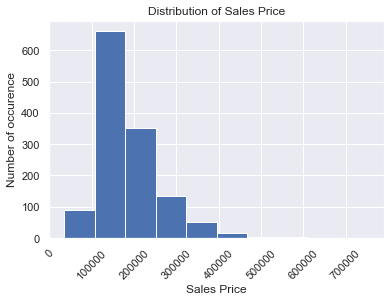

In [7]:
plt.hist(df2['saleprice'])
plt.title('Distribution of Sales Price')
plt.ylabel('Number of occurence')
plt.xlabel('Sales Price')
plt.xticks(rotation = 45)
plt.show()

In [8]:
df1.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Check for Correlation Between Numerical Columns to Limit Data

In [9]:
non_numeric = df1.select_dtypes(include = 'object')
numeric = df1.select_dtypes(include = ['float64', 'int64'])

In [10]:
# Correlation coefficient
numeric.corr().abs().sort_values(by = 'saleprice', ascending = False)

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
saleprice,0.021917,0.084284,0.351799,0.263843,0.790982,0.077856,0.522897,0.507101,0.477493,0.386420,...,0.324413,0.315856,0.128578,0.044584,0.111447,0.092404,0.021190,0.046432,0.028923,1.000000
overallqual,0.028365,0.032628,0.251646,0.105806,1.000000,0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,0.113937,0.030371,0.064886,0.065166,0.031406,0.070815,0.027347,0.790982
grlivarea,0.008273,0.074853,0.402797,0.263116,0.593007,0.079686,0.199010,0.287389,0.390857,0.208171,...,0.247433,0.330224,0.009113,0.020643,0.101510,0.170205,0.002416,0.050240,0.036526,0.708624
garagecars,0.016570,0.040110,0.285691,0.154871,0.600671,0.185758,0.537850,0.420622,0.364204,0.224054,...,0.226342,0.213569,0.151434,0.035765,0.050494,0.020934,0.043080,0.040522,0.039117,0.640409
garagearea,0.017634,0.098672,0.344997,0.180403,0.562022,0.151521,0.478954,0.371600,0.373066,0.296970,...,0.224666,0.241435,0.121777,0.035087,0.051412,0.061047,0.027400,0.027974,0.027378,0.623431
totalbsmtsf,0.015415,0.238518,0.392075,0.260833,0.537808,0.171098,0.391452,0.291066,0.363936,0.522396,...,0.232019,0.247264,0.095478,0.037384,0.084489,0.126053,0.018479,0.013196,0.014969,0.613581
firstflrsf,0.010496,0.251758,0.457181,0.299475,0.476224,0.144203,0.281986,0.240379,0.344501,0.445863,...,0.235459,0.211671,0.065292,0.056104,0.088758,0.131525,0.021096,0.031372,0.013604,0.605852
fullbath,0.005587,0.131608,0.198769,0.126031,0.550600,0.194149,0.468271,0.439046,0.276833,0.058543,...,0.187703,0.259977,0.115093,0.035353,0.008106,0.049604,0.014290,0.055872,0.019669,0.560664
totrmsabvgrd,0.027239,0.040380,0.352096,0.190015,0.427452,0.057583,0.095589,0.191740,0.280682,0.044316,...,0.165984,0.234192,0.004151,0.006683,0.059383,0.083757,0.024763,0.036907,0.034516,0.533723
yearbuilt,0.012713,0.027850,0.123349,0.014228,0.572323,0.375983,1.000000,0.592855,0.315707,0.249503,...,0.224880,0.188686,0.387268,0.031355,0.050364,0.004950,0.034383,0.012398,0.013618,0.522897


In [11]:
#pick top 5 numeric:
df3 = df2.loc[:, ['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'saleprice']]

## Check for Correlation With Non-Numerical Columns to Limit Data

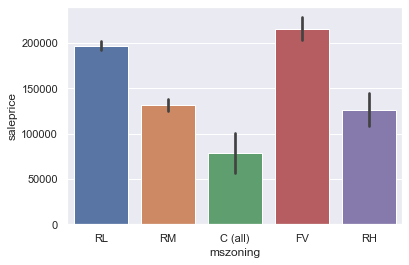

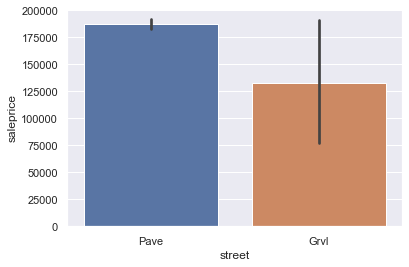

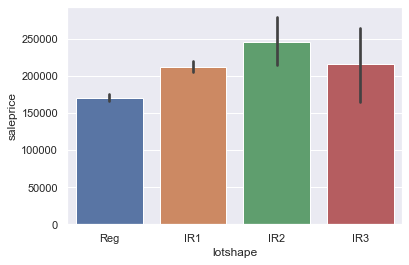

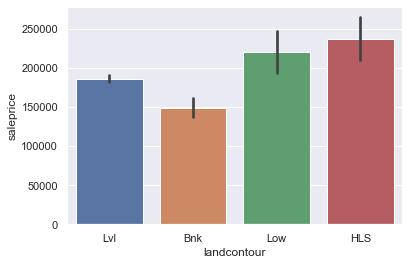

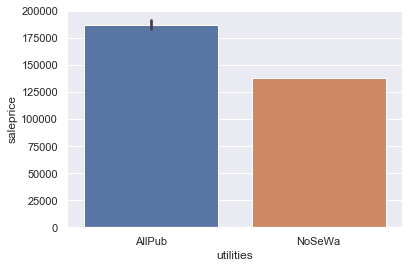

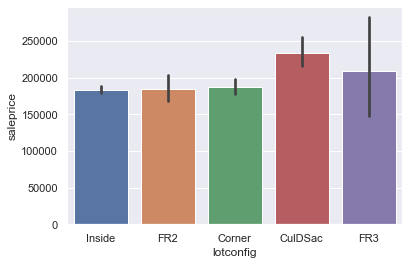

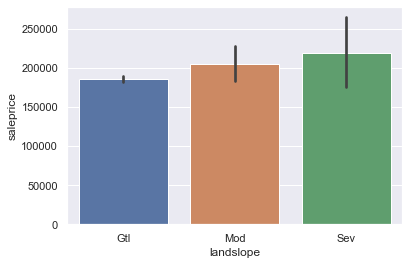

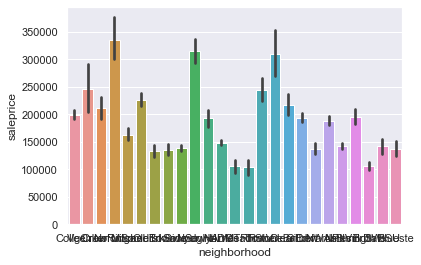

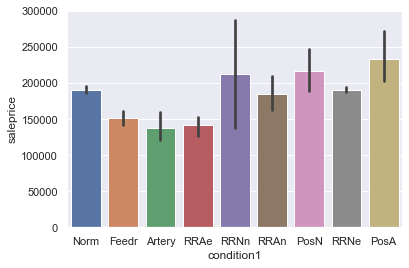

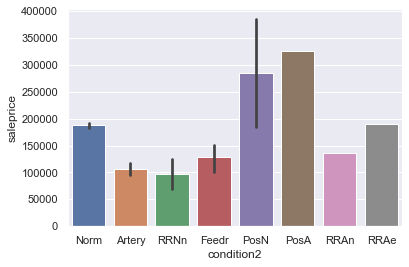

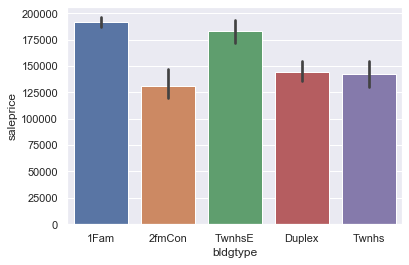

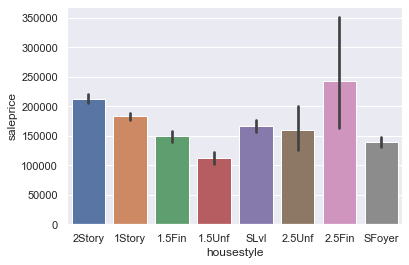

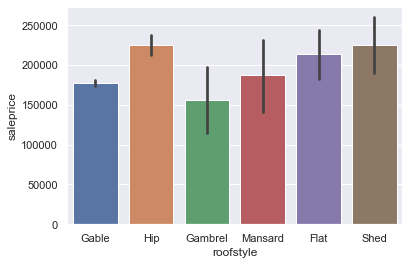

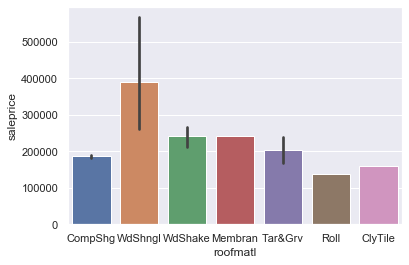

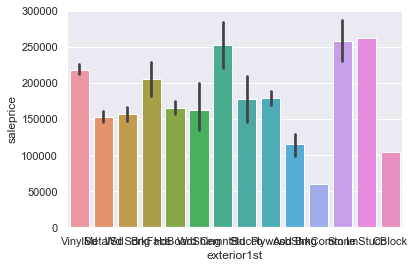

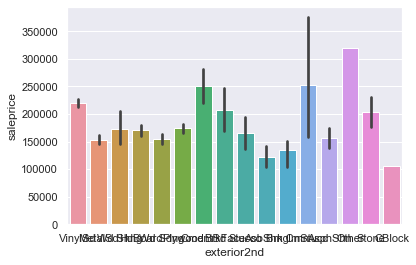

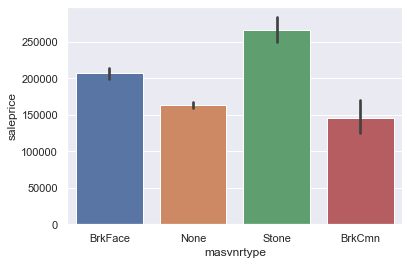

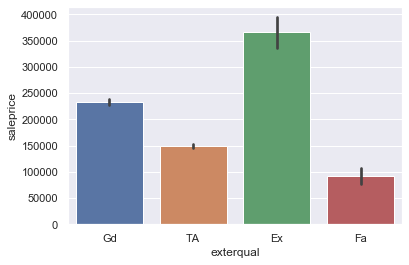

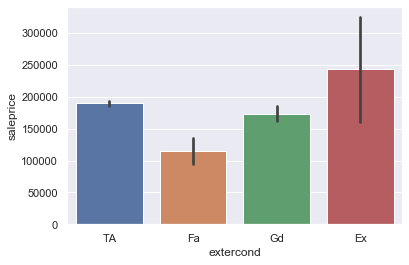

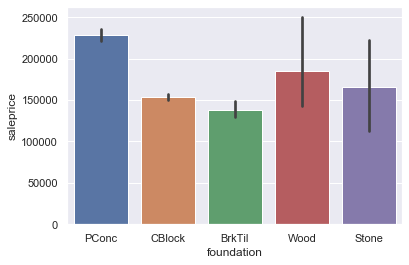

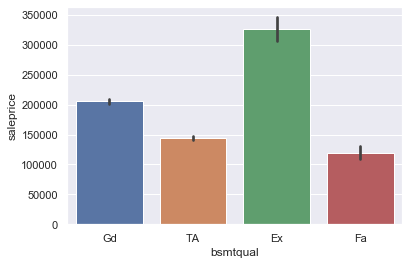

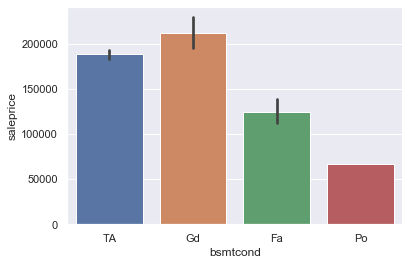

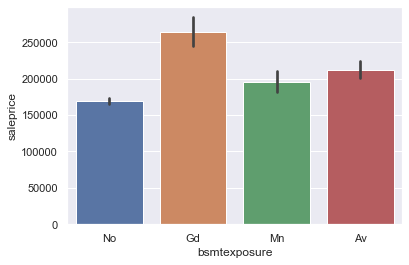

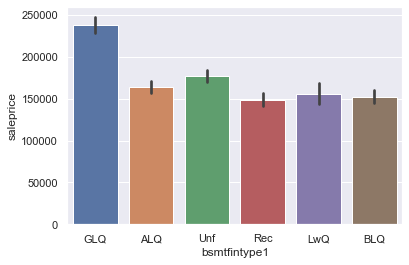

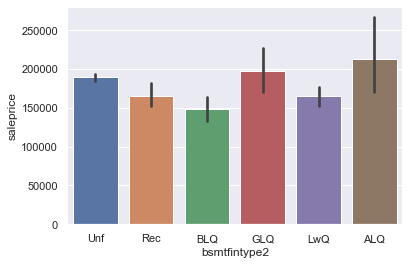

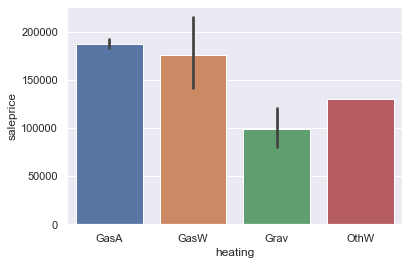

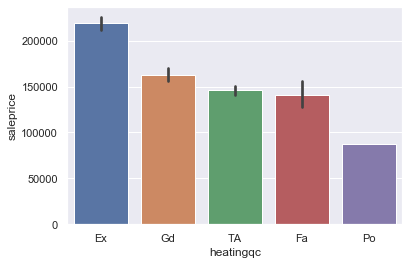

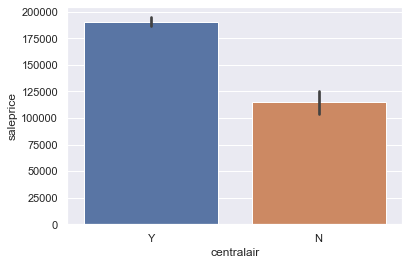

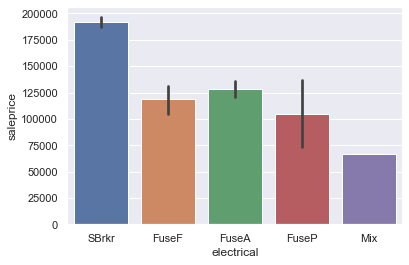

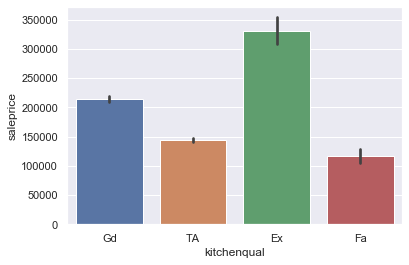

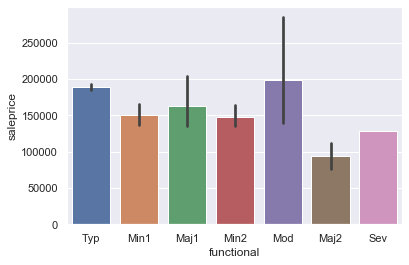

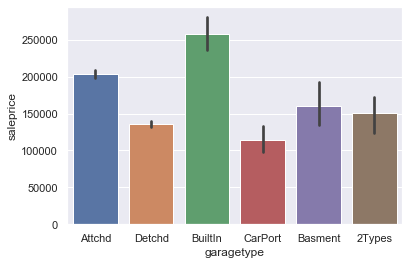

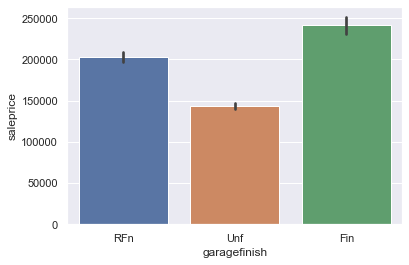

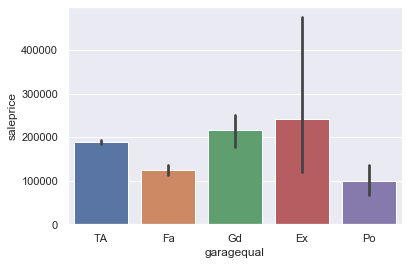

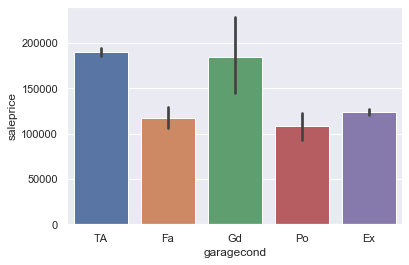

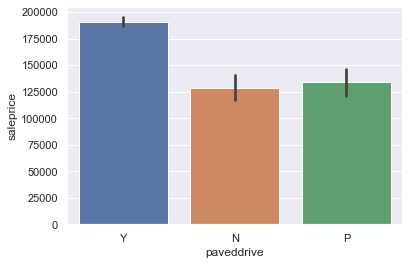

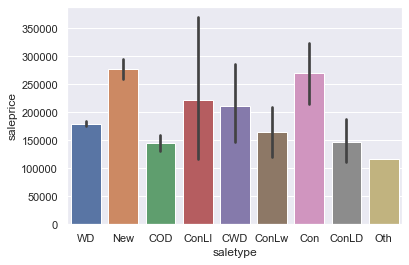

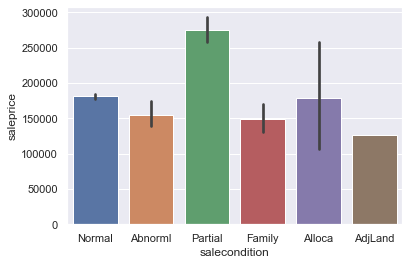

In [12]:
non_numeric_columns = list(non_numeric.columns)

for col in non_numeric_columns:
    sns.barplot(df2[col], df2['saleprice'])
    plt.show()

In [13]:
#Choose Central Air and External Quality as the features I'll use for the model
df4 = df2.loc[:, ['exterqual', 'centralair']]

#One Hot encoding of categorical variables
df5 = pd.get_dummies(df4, columns = ['exterqual', 'centralair'])

In [14]:
#Combine Dataframes
df3
df5
model_df = pd.concat([df3, df5], axis = 1)

model_df.head()

,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf,saleprice,exterqual_Ex,exterqual_Fa,exterqual_Gd,exterqual_TA,centralair_N,centralair_Y
0,7,1710,2,548,856,208500,0,0,1,0,0,1
1,6,1262,2,460,1262,181500,0,0,0,1,0,1
2,7,1786,2,608,920,223500,0,0,1,0,0,1
3,7,1717,3,642,756,140000,0,0,0,1,0,1
4,8,2198,3,836,1145,250000,0,0,1,0,0,1


## Build Model

In [18]:
#Separate target variable from rest of data
X = model_df.drop(columns = 'saleprice')
y = model_df['saleprice']

#split train_test
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [21]:
# We create a LinearRegression model 

lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Assumption one: linearity of the model in its coefficients should be a linear relationship in the visual

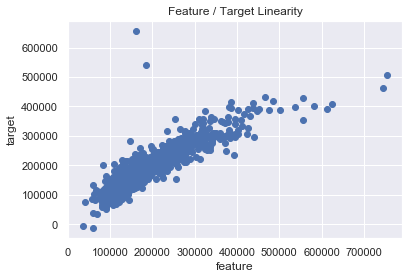

In [22]:
predictions = lrm.predict(X)
plt.scatter(model_df["saleprice"], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Feature / Target Linearity')
plt.show()

PASS. This is a fairly linear relationship. 

## Assumption two: the error term should be zero on average

In [23]:
predictions = lrm.predict(X)
errors = y - predictions

print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -4.3335559386449086e-11


PASS. The mean of error terms is very close to zero. 

## Assumption three: homoscedasticity|

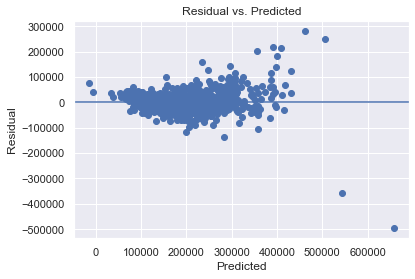

In [24]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


PASS. The errors center around zero although there some outliers. 

## Assumption four: low multicollinearity

In [28]:
X = add_constant(X)
pd.Series([variance_inflation_factor(X.values, i)
for i in range (X.shape[1])], index=X.columns)

/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


const           0.000000
overallqual     2.902392
grlivarea       1.709362
garagecars      3.687292
garagearea      3.562147
totalbsmtsf     1.634269
exterqual_Ex         inf
exterqual_Fa         inf
exterqual_Gd         inf
exterqual_TA         inf
centralair_N         inf
centralair_Y         inf
dtype: float64

PASS: The correlations are all below 5. 

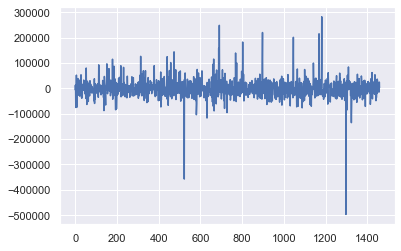

In [29]:
plt.plot(errors)
plt.show()

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


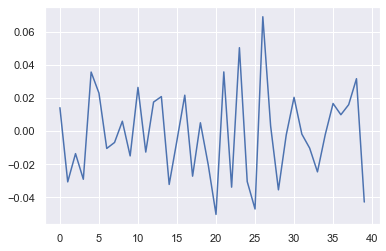

In [30]:
acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

PASS: Correlation is low (ranges from -.05 to .07). 

## Assumption six: features shouldn't be correlated with the errors

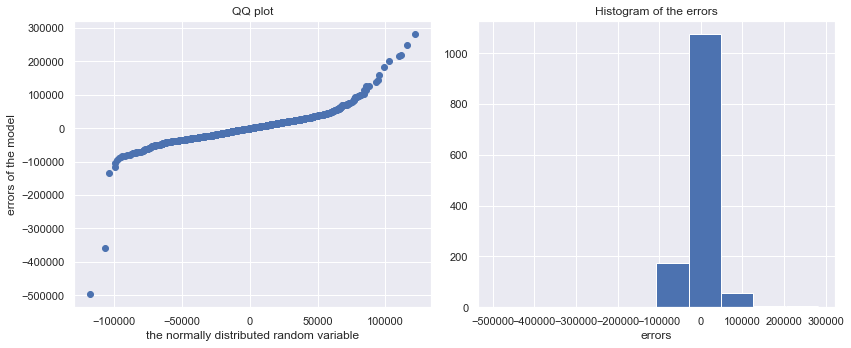

In [31]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [34]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 68036.53792667245 and p value is 0.0
Normality test statistics is 603.3430166505339 and p value is 9.676729183734956e-132


PASS: Pvalues are below .05

## Conclusion

If any of the assumptions were not met, we would need to reevaluate our model band include additional variables or exclude problematic ones.